# Capstone Project Notebook


In [107]:
import pandas as pd
import numpy as np

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import urllib

print('Libraries imported.')

#!conda install -c conda-forge beautifulsoup4 --yes
from bs4 import BeautifulSoup as bs

print('Beautiful soup imported.')

Libraries imported.
Beautiful soup imported.


In [108]:
url = 'https://en.wikipedia.org/wiki/List_of_cities_in_the_European_Union_by_population_within_city_limits'
html_doc = urllib.request.urlopen(url)

In [109]:
soup = bs(html_doc, 'html.parser')
table = soup.find_all('table')[0]

In [110]:
# get data from Table
row_marker = 0
numcities = 20
citylist = pd.DataFrame(columns=['City Name','Country','Latitude','Longitude'], index = range(0,numcities)) # I know the size
for cnt in range(0,6*numcities,6):
    column = table.find_all('td')[cnt] # Grab the first column
    textstring = (column.get_text().replace('\n',''))
    if textstring.find('[') != -1:
        textstring = textstring[0:textstring.find('[')]
    citylist.iat[row_marker,0] = textstring
    
    column = table.find_all('td')[cnt+1] # Grab the next column
    textstring = (column.get_text().replace('\n',''))
    citylist.iat[row_marker,1] = textstring
    
    row_marker += 1
    
datasize = citylist.shape
print('Size of Dataframe: '+str(datasize))

Size of Dataframe: (20, 4)


In [111]:
citylist.head(20)

,City Name,Country,Latitude,Longitude
0,London,United Kingdom,NaN,NaN
1,Berlin,Germany,NaN,NaN
2,Madrid,Spain,NaN,NaN
3,Rome,Italy,NaN,NaN
4,Paris,France,NaN,NaN
5,Bucharest,Romania,NaN,NaN
6,Vienna,Austria,NaN,NaN
7,Hamburg,Germany,NaN,NaN
8,Warsaw,Poland,NaN,NaN
9,Budapest,Hungary,NaN,NaN


In [112]:
for cnt in range(0,20):
    address = citylist.iloc[cnt,0]+','+citylist.iloc[cnt,1]
    geolocator = Nominatim(user_agent="explorer")
    location = geolocator.geocode(address)
    citylist.iat[cnt,2] = location.latitude
    citylist.iat[cnt,3] = location.longitude

     
citylist.head()

,City Name,Country,Latitude,Longitude
0,London,United Kingdom,51.5073,-0.127647
1,Berlin,Germany,52.517,13.3889
2,Madrid,Spain,40.4167,-3.70358
3,Rome,Italy,41.8948,12.4853
4,Paris,France,48.8566,2.3515


In [121]:
# create map
euromap = folium.Map(location=[45, 5], zoom_start=4)

# add markers to the map
markers_colors = []
for lat, lon, cit in zip(citylist['Latitude'], citylist['Longitude'], citylist['City Name']):
    label = folium.Popup(str(cit), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(euromap)
       
euromap

In [122]:
CLIENT_ID = 'GAKODM4LPGEUSDE4NFZUMTWDTMGN1JUAJZLISCRAMHKW5DYW' # your Foursquare ID
CLIENT_SECRET = 'JZDLW4BA33DDRBTABFIC5O4JTWXJY5TVA2AKRADI5YP12OK4' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GAKODM4LPGEUSDE4NFZUMTWDTMGN1JUAJZLISCRAMHKW5DYW
CLIENT_SECRET:JZDLW4BA33DDRBTABFIC5O4JTWXJY5TVA2AKRADI5YP12OK4


In [123]:
def getNearbyVenues(names, latitudes, longitudes, radius=3000):
    
    sectionlist =  ['food', 'drinks', 'coffee', 'shops', 'arts']
    venues_list=[]
    
    for cnt in range(0,len(sectionlist)):
    
        section = sectionlist[cnt]
        print('Section '+ section)
   
        for name, lat, lng in zip(names, latitudes, longitudes):
                       
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&section={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                section,
                LIMIT)
            
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
            skipcounter = 0
            for cnt in range(0,len(results)):
            
                try:
                                
                # return only relevant information for each nearby venue
                    venues_list.append([(
                    name, 
                    results[cnt]['venue']['location']['postalCode'],
                    results[cnt]['venue']['name'],
                    results[cnt]['venue']['location']['lat'], 
                    results[cnt]['venue']['location']['lng'],  
                    results[cnt]['venue']['categories'][0]['name'])])
                
                except:
                    skipcounter = skipcounter+1
                
            print('City ' + name + ': ' + str(skipcounter) + ' venues skipped')

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'Postal Code',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [125]:
european_venues = getNearbyVenues(names=citylist['City Name'],
                                   latitudes=citylist['Latitude'],
                                   longitudes=citylist['Longitude']
                                  )

Section food
City London: 1 venues skipped
City Berlin: 1 venues skipped
City Madrid: 6 venues skipped
City Rome: 19 venues skipped
City Paris: 0 venues skipped
City Bucharest: 52 venues skipped
City Vienna: 8 venues skipped
City Hamburg: 4 venues skipped
City Warsaw: 38 venues skipped
City Budapest: 11 venues skipped
City Barcelona: 6 venues skipped
City Munich: 3 venues skipped
City Milan: 11 venues skipped
City Prague: 7 venues skipped
City Sofia: 33 venues skipped
City Brussels: 2 venues skipped
City Birmingham: 3 venues skipped
City Cologne: 2 venues skipped
City Naples: 34 venues skipped
City Stockholm: 14 venues skipped
Section drinks
City London: 1 venues skipped
City Berlin: 0 venues skipped
City Madrid: 8 venues skipped
City Rome: 11 venues skipped
City Paris: 0 venues skipped
City Bucharest: 41 venues skipped
City Vienna: 10 venues skipped
City Hamburg: 1 venues skipped
City Warsaw: 44 venues skipped
City Budapest: 8 venues skipped
City Barcelona: 14 venues skipped
City Muni

In [127]:
european_venues.tail()

,City,Postal Code,Venue,Venue Latitude,Venue Longitude,Venue Category
8409,Stockholm,118 26,Filmstaden Söder,59.314108,18.070973,Multiplex
8410,Stockholm,111 53,Stora Scenen,59.331325,18.071584,Concert Hall
8411,Stockholm,111 48,Stallet,59.330912,18.075786,Concert Hall
8412,Stockholm,116 22,Kellys,59.314398,18.074586,Rock Club
8413,Stockholm,111 49,Moderna Dansteatern,59.327330,18.083755,Dance Studio


In [128]:
#print(european_venues.shape)

#european_venues.drop_duplicates(subset=None, keep='first', inplace=True)

#print(european_venues.shape)


print('The dataframe has {} postal codes/neighborhoods and {} venues.'.format(
        len(european_venues['Postal Code'].unique()),
        european_venues.shape[0]
    )
)

The dataframe has 1472 postal codes/neighborhoods and 8414 venues.


In [129]:
print('There are {} unique categories.'.format(len(european_venues['Venue Category'].unique())))

There are 291 unique categories.


In [130]:
for cnt in range(0,citylist.shape[0]):
    blurb = european_venues.loc[european_venues['City']==citylist.iloc[cnt,0]].groupby('Postal Code').count()
    print(citylist.iloc[cnt,0]+': '+str(blurb.shape[0])+' neighborhoods/postal codes')


London: 422 neighborhoods/postal codes
Berlin: 18 neighborhoods/postal codes
Madrid: 17 neighborhoods/postal codes
Rome: 25 neighborhoods/postal codes
Paris: 14 neighborhoods/postal codes
Bucharest: 180 neighborhoods/postal codes
Vienna: 17 neighborhoods/postal codes
Hamburg: 20 neighborhoods/postal codes
Warsaw: 161 neighborhoods/postal codes
Budapest: 58 neighborhoods/postal codes
Barcelona: 27 neighborhoods/postal codes
Munich: 27 neighborhoods/postal codes
Milan: 21 neighborhoods/postal codes
Prague: 23 neighborhoods/postal codes
Sofia: 27 neighborhoods/postal codes
Brussels: 11 neighborhoods/postal codes
Birmingham: 248 neighborhoods/postal codes
Cologne: 23 neighborhoods/postal codes
Naples: 18 neighborhoods/postal codes
Stockholm: 128 neighborhoods/postal codes


### London and Birmingham have an extremely large number of postal codes - in the UK the postal code areas are quite small. For this reason, we will drop the final digits/letters for these postal codes, generating larger neighborhoods. In Warsaw and Bucharest we will do the same, dropping two final digits. In Stockholm we will drop the final digit.

In [131]:
european_venues.loc[european_venues['City']=='London','Postal Code'] = european_venues.loc[european_venues['City']=='London','Postal Code'].str[:-2]

In [132]:
european_venues.loc[european_venues['City']=='Birmingham','Postal Code'] = european_venues.loc[european_venues['City']=='Birmingham','Postal Code'].str[:-2]

In [133]:
european_venues.loc[european_venues['City']=='Warsaw','Postal Code'] = european_venues.loc[european_venues['City']=='Warsaw','Postal Code'].str[:-2]

In [134]:
european_venues.loc[european_venues['City']=='Bucharest','Postal Code'] = european_venues.loc[european_venues['City']=='Bucharest','Postal Code'].str[:-2]

In [135]:
european_venues.loc[european_venues['City']=='Stockholm','Postal Code'] = european_venues.loc[european_venues['City']=='Stockholm','Postal Code'].str.slice(0,-1)

In [136]:
for cnt in range(0,citylist.shape[0]):
    blurb = european_venues.loc[european_venues['City']==citylist.iloc[cnt,0]].groupby('Postal Code').count()
    print(citylist.iloc[cnt,0]+': '+str(blurb.shape[0])+' neighborhoods/postal codes')

London: 100 neighborhoods/postal codes
Berlin: 18 neighborhoods/postal codes
Madrid: 17 neighborhoods/postal codes
Rome: 25 neighborhoods/postal codes
Paris: 14 neighborhoods/postal codes
Bucharest: 56 neighborhoods/postal codes
Vienna: 17 neighborhoods/postal codes
Hamburg: 20 neighborhoods/postal codes
Warsaw: 17 neighborhoods/postal codes
Budapest: 58 neighborhoods/postal codes
Barcelona: 27 neighborhoods/postal codes
Munich: 27 neighborhoods/postal codes
Milan: 21 neighborhoods/postal codes
Prague: 23 neighborhoods/postal codes
Sofia: 27 neighborhoods/postal codes
Brussels: 11 neighborhoods/postal codes
Birmingham: 34 neighborhoods/postal codes
Cologne: 23 neighborhoods/postal codes
Naples: 18 neighborhoods/postal codes
Stockholm: 41 neighborhoods/postal codes


In [137]:
print(str(european_venues.shape[0]) + ' Venues')
print(str(european_venues.groupby('Postal Code').count().shape[0]) + ' Neighborhoods')

8414 Venues
583 Neighborhoods


Text(0, 0.5, 'Number of Neighborhoods')

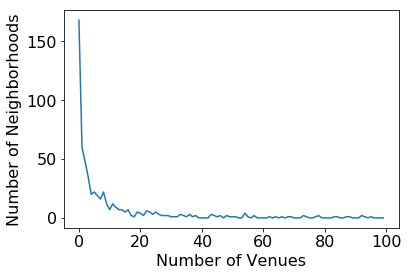

In [138]:
blurb = european_venues.groupby('Postal Code').count()
location_counter = np.zeros([100,1])
for cnt in range(0,100):
    location_counter[cnt] = np.sum(blurb['City'] == cnt+1)
    
plt.plot(location_counter)
plt.xlabel('Number of Venues')
plt.ylabel('Number of Neighborhoods')

## get rid of postal codes with only 1 or 2 venues, since we will not be able to do any sensible analysis with these postal codes/neighborhoods

In [139]:
european_venues.head()

,City,Postal Code,Venue,Venue Latitude,Venue Longitude,Venue Category
0,London,WC2N 4,Barrafina,51.509427,-0.125894,Spanish Restaurant
1,London,WC2N 4,Tandoor Chop House,51.509103,-0.125987,North Indian Restaurant
2,London,SW1Y 4,Milos,51.508117,-0.133341,Greek Restaurant
3,London,SW1Y 4,Ole & Steen,51.509219,-0.132597,Bakery
4,London,WC2N 4,Wahaca,51.510221,-0.124524,Mexican Restaurant


In [140]:
indexNames = blurb[blurb['City'] <= 2].index

for cnt in range(0,len(indexNames)):
    european_venues = european_venues[european_venues['Postal Code'] != indexNames[cnt]]

In [141]:
print(str(european_venues.shape[0]) + ' Venues')
print(str(european_venues.groupby('Postal Code').count().shape[0]) + ' Neighborhoods') 
print('There are {} unique categories.'.format(len(european_venues['Venue Category'].unique())))

8126 Venues
355 Neighborhoods
There are 289 unique categories.


In [143]:
# one hot encoding
european_venues_onehot = pd.get_dummies(european_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
european_venues_onehot['Postal Code'] = european_venues['Postal Code'] 

# move neighborhood column to the first column
fixed_columns = [european_venues_onehot.columns[-1]] + list(european_venues_onehot.columns[:-1])
european_venues_onehot = european_venues_onehot[fixed_columns]

european_venues_onehot.head(5)

,Postal Code,Abruzzo Restaurant,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Volleyball Court,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Zoo Exhibit
0,WC2N 4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,WC2N 4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,SW1Y 4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,SW1Y 4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,WC2N 4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [144]:
european_grouped = european_venues_onehot.groupby('Postal Code').mean().reset_index()

In [145]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [146]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Postal Code'] = european_grouped['Postal Code']

for ind in np.arange(european_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(european_grouped.iloc[ind, :], num_top_venues)

# Cluster the neighborhoods

[ 83  70 202]
[ 27  45 207  76]
[ 17  41  73 179  45]
[186  42  12   9  35  71]
[ 63 138   7  53  26  32  36]
[  9  18  32   9  49 164  72   2]


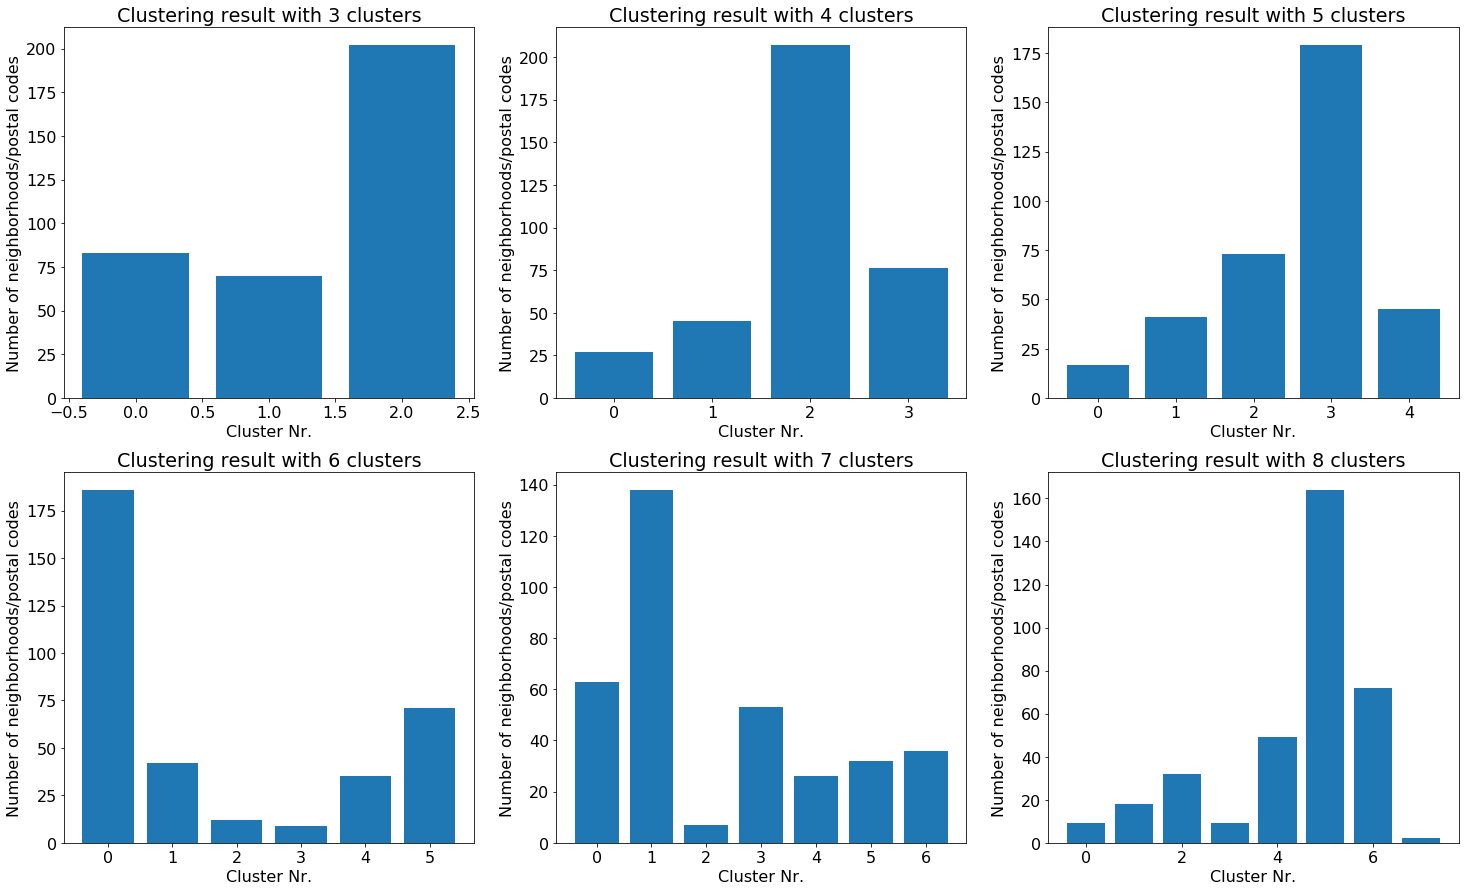

In [186]:
# set maximum number of clusters
kclusters = 8

european_grouped_clustering = european_grouped.drop('Postal Code', 1)

for k in range(3,kclusters+1):

    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(european_grouped_clustering)
    unique, counts = np.unique(kmeans.labels_, return_counts=True)

    print(counts)
    
    plt.figure(1,figsize=(25,15))
    plt.subplot(231+k-3)
    plt.bar(unique,counts)
    plt.xlabel('Cluster Nr.')
    plt.ylabel('Number of neighborhoods/postal codes')
    plt.title('Clustering result with '+str(k)+ ' clusters')
    plt.rcParams.update({'font.size': 16})

## we choose k = 5 clusters and rerun the fit

In [148]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(european_grouped_clustering)

In [149]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhoods_venues_sorted.head(10)
#neighborhoods_venues_sorted.shape
european_merged = european_venues

# merge to add city information
european_merged = european_merged.join(neighborhoods_venues_sorted.set_index('Postal Code'), on='Postal Code')

european_merged.head()

,City,Postal Code,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,London,WC2N 4,Barrafina,51.509427,-0.125894,Spanish Restaurant,1,Theater,Coffee Shop,Café,Pub,Speakeasy,Mexican Restaurant,North Indian Restaurant,Opera House,Tea Room,Spanish Restaurant
1,London,WC2N 4,Tandoor Chop House,51.509103,-0.125987,North Indian Restaurant,1,Theater,Coffee Shop,Café,Pub,Speakeasy,Mexican Restaurant,North Indian Restaurant,Opera House,Tea Room,Spanish Restaurant
2,London,SW1Y 4,Milos,51.508117,-0.133341,Greek Restaurant,1,Theater,Bar,Cocktail Bar,Japanese Restaurant,Greek Restaurant,Comedy Club,Bakery,Electronics Store,English Restaurant,Ethiopian Restaurant
3,London,SW1Y 4,Ole & Steen,51.509219,-0.132597,Bakery,1,Theater,Bar,Cocktail Bar,Japanese Restaurant,Greek Restaurant,Comedy Club,Bakery,Electronics Store,English Restaurant,Ethiopian Restaurant
4,London,WC2N 4,Wahaca,51.510221,-0.124524,Mexican Restaurant,1,Theater,Coffee Shop,Café,Pub,Speakeasy,Mexican Restaurant,North Indian Restaurant,Opera House,Tea Room,Spanish Restaurant


## Examine Clusters

In [150]:
european_merged.loc[european_merged['Cluster Labels'] == 0, european_merged.columns[[1,2] + list(range(5, european_merged.shape[1]))]].head()

,Postal Code,Venue,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
510,0306,Trattoria Adagio,Italian Restaurant,0,Department Store,Italian Restaurant,Supermarket,Farmers Market,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant
518,0205,Kāne World Food Studio,Restaurant,0,Restaurant,Supermarket,Grocery Store,Zoo Exhibit,Fabric Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space
1272,1606,Магданоз (Magdanoz),Bulgarian Restaurant,0,Bulgarian Restaurant,Dance Studio,Supermarket,Zoo Exhibit,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market
1470,B15 1,Nando's,Portuguese Restaurant,0,Portuguese Restaurant,Supermarket,Café,Coffee Shop,Multiplex,Fish Market,Fish & Chips Shop,Flea Market,Fast Food Restaurant,Farmers Market
1600,80100,Trattoria Da Nennella,Italian Restaurant,0,Coffee Shop,Supermarket,Italian Restaurant,Cupcake Shop,Optical Shop,Café,Cocktail Bar,Theater,Design Studio,Ethiopian Restaurant


In [151]:
european_merged.loc[european_merged['Cluster Labels'] == 1, european_merged.columns[[1,2] + list(range(5, european_merged.shape[1]))]].head()

,Postal Code,Venue,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,WC2N 4,Barrafina,Spanish Restaurant,1,Theater,Coffee Shop,Café,Pub,Speakeasy,Mexican Restaurant,North Indian Restaurant,Opera House,Tea Room,Spanish Restaurant
1,WC2N 4,Tandoor Chop House,North Indian Restaurant,1,Theater,Coffee Shop,Café,Pub,Speakeasy,Mexican Restaurant,North Indian Restaurant,Opera House,Tea Room,Spanish Restaurant
2,SW1Y 4,Milos,Greek Restaurant,1,Theater,Bar,Cocktail Bar,Japanese Restaurant,Greek Restaurant,Comedy Club,Bakery,Electronics Store,English Restaurant,Ethiopian Restaurant
3,SW1Y 4,Ole & Steen,Bakery,1,Theater,Bar,Cocktail Bar,Japanese Restaurant,Greek Restaurant,Comedy Club,Bakery,Electronics Store,English Restaurant,Ethiopian Restaurant
4,WC2N 4,Wahaca,Mexican Restaurant,1,Theater,Coffee Shop,Café,Pub,Speakeasy,Mexican Restaurant,North Indian Restaurant,Opera House,Tea Room,Spanish Restaurant


In [152]:
european_merged.loc[european_merged['Cluster Labels'] == 2, european_merged.columns[[1,2] + list(range(5, european_merged.shape[1]))]].head()

,Postal Code,Venue,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
56,W1S 3,Thomas's at Burberry Regent Street,Café,2,Café,Clothing Store,Italian Restaurant,Zoo Exhibit,Farmers Market,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant
72,W1S 3,Cecconi's,Italian Restaurant,2,Café,Clothing Store,Italian Restaurant,Zoo Exhibit,Farmers Market,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant
98,W1J 7,Burger & Lobster,Seafood Restaurant,2,Tea Room,Café,Seafood Restaurant,Social Club,Zoo Exhibit,Fabric Shop,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit
136,10119,Cocolo Ramen,Ramen Restaurant,2,Café,Breakfast Spot,Vietnamese Restaurant,Bar,Beer Bar,Cocktail Bar,Italian Restaurant,Wine Bar,Coffee Shop,French Restaurant
140,10119,Shiso Burger,Burger Joint,2,Café,Breakfast Spot,Vietnamese Restaurant,Bar,Beer Bar,Cocktail Bar,Italian Restaurant,Wine Bar,Coffee Shop,French Restaurant


In [153]:
european_merged.loc[european_merged['Cluster Labels'] == 3, european_merged.columns[[1,2] + list(range(5, european_merged.shape[1]))]].head()

,Postal Code,Venue,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,WC2E 8,Flat Iron,Steakhouse,3,Sushi Restaurant,Café,French Restaurant,Steakhouse,Comedy Club,Shopping Plaza,Electronics Store,Falafel Restaurant,Ethiopian Restaurant,Event Space
7,WC2E 8,Sticks'n'Sushi,Sushi Restaurant,3,Sushi Restaurant,Café,French Restaurant,Steakhouse,Comedy Club,Shopping Plaza,Electronics Store,Falafel Restaurant,Ethiopian Restaurant,Event Space
9,WC2E 8,Clos Maggiore,French Restaurant,3,Sushi Restaurant,Café,French Restaurant,Steakhouse,Comedy Club,Shopping Plaza,Electronics Store,Falafel Restaurant,Ethiopian Restaurant,Event Space
11,WC2E 9,Five Guys,Burger Joint,3,Clothing Store,Opera House,Burger Joint,Cocktail Bar,Liquor Store,Wine Bar,Pub,Deli / Bodega,English Restaurant,Ethiopian Restaurant
17,WC2E 8,SUSHISAMBA Covent Garden,Sushi Restaurant,3,Sushi Restaurant,Café,French Restaurant,Steakhouse,Comedy Club,Shopping Plaza,Electronics Store,Falafel Restaurant,Ethiopian Restaurant,Event Space


In [154]:
european_merged.loc[european_merged['Cluster Labels'] == 4, european_merged.columns[[1,2] + list(range(5, european_merged.shape[1]))]].head()

,Postal Code,Venue,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,WC2H 9,Dishoom,Indian Restaurant,4,Coffee Shop,Wine Bar,Indian Restaurant,Theater,Tea Room,French Restaurant,Steakhouse,Mediterranean Restaurant,Lounge,Bakery
12,WC2E 7,Franco Manca,Pizza Place,4,Coffee Shop,Pizza Place,Gift Shop,History Museum,Korean Restaurant,Theater,Italian Restaurant,Fast Food Restaurant,Farmers Market,Fish & Chips Shop
15,WC2H 9,Hawksmoor Seven Dials,Steakhouse,4,Coffee Shop,Wine Bar,Indian Restaurant,Theater,Tea Room,French Restaurant,Steakhouse,Mediterranean Restaurant,Lounge,Bakery
16,WC2H 9,Fabrique,Bakery,4,Coffee Shop,Wine Bar,Indian Restaurant,Theater,Tea Room,French Restaurant,Steakhouse,Mediterranean Restaurant,Lounge,Bakery
20,WC2H 9,L'Atelier de Joel Robuchon,French Restaurant,4,Coffee Shop,Wine Bar,Indian Restaurant,Theater,Tea Room,French Restaurant,Steakhouse,Mediterranean Restaurant,Lounge,Bakery


## List of venues which could be possible concert locations

In [156]:
venues_of_interest = ['Rock Club','Concert Hall','Piano Bar','Irish Pub','Jazz Club','Performing Arts Venue','Theater','Karaoke Bar','Music Venue','Opera House','Amphitheater','Salsa Club','Country Dance Club','Cultural Center','General Entertainment']
european_venue_list = european_merged.loc[european_merged['Venue Category'].isin(venues_of_interest)]

## Set reference venue

First test case: Ampere

In [176]:
reference_cluster = european_merged['Cluster Labels'].loc[european_merged['Venue'] == "Ampere"]
reference_cluster = reference_cluster.iloc[0]
print('Reference cluster is number '+str(reference_cluster))

Reference cluster is number 2


In [177]:
proposed_venues = european_venue_list.loc[european_venue_list['Cluster Labels'] == reference_cluster]
proposed_venues = proposed_venues[['City','Postal Code','Venue','Venue Category','Cluster Labels']]

In [178]:
proposed_venues.shape

(80, 5)

In [179]:
proposed_venues.head(10)

,City,Postal Code,Venue,Venue Category,Cluster Labels
1015,Munich,80336,Kennedy's Irish Bar & Restaurant,Irish Pub,2
2370,Vienna,1090,Charlie P's,Irish Pub,2
2508,Warsaw,00-6,miejsce Chwila,Rock Club,2
2526,Warsaw,00-6,12on14 Jazz Club,Jazz Club,2
2749,Munich,80333,Rote Sonne,Music Venue,2
2763,Munich,81667,Muffathalle,Music Venue,2
2771,Munich,81667,Ampere,Rock Club,2
3377,Naples,80134,Alter Ego,Music Venue,2
4246,Warsaw,00-3,Chopin Point Warsaw,Concert Hall,2
4894,Birmingham,B12 9,mac birmingham,Performing Arts Venue,2


## Set reference venue

Second test case: Costello Club

In [180]:
reference_cluster = european_merged['Cluster Labels'].loc[european_merged['Venue'] == "Costello Club"]
reference_cluster = reference_cluster.iloc[0]
print('Reference cluster is number '+str(reference_cluster))

Reference cluster is number 3


In [181]:
proposed_venues = european_venue_list.loc[european_venue_list['Cluster Labels'] == reference_cluster]
proposed_venues = proposed_venues[['City','Postal Code','Venue','Venue Category','Cluster Labels']]
proposed_venues.shape

(411, 5)

In [182]:
proposed_venues.head(10)

,City,Postal Code,Venue,Venue Category,Cluster Labels
501,Bucharest,0300,St. Patrick,Irish Pub,3
587,Vienna,1010,Pickwick's,Irish Pub,3
956,Munich,80331,Kilians,Irish Pub,3
1755,London,W1D 4,Ronnie Scott's Jazz Club,Jazz Club,3
1859,Berlin,10117,Vincent,Piano Bar,3
1952,Madrid,28004,Microteatro por dinero,Performing Arts Venue,3
1972,Madrid,28013,Costello Club,Concert Hall,3
2011,Madrid,28004,Toni 2,Piano Bar,3
2053,Rome,00187,Gregory's Jazz Club,Jazz Club,3
2254,Bucharest,0300,MOJO,Karaoke Bar,3


## Set reference venue

Third test case: VK Concerts

In [183]:
reference_cluster = european_merged['Cluster Labels'].loc[european_merged['Venue'] == "VK Concerts"]
reference_cluster = reference_cluster.iloc[0]
print('Reference cluster is number '+str(reference_cluster))

Reference cluster is number 4


In [184]:
proposed_venues = european_venue_list.loc[european_venue_list['Cluster Labels'] == reference_cluster]
proposed_venues = proposed_venues[['City','Postal Code','Venue','Venue Category','Cluster Labels']]
proposed_venues.shape

(37, 5)

In [185]:
proposed_venues.head(10)

,City,Postal Code,Venue,Venue Category,Cluster Labels
3313,Cologne,51063,Gebäude 9,Music Venue,4
6836,London,WC2E 7,Lyceum Theatre,Theater,4
6859,London,WC2H 9,The Hospital Club,Performing Arts Venue,4
6867,London,WC2H 9,Ambassadors Theatre,Theater,4
6870,London,WC2H 9,St Martin's Theatre,Theater,4
6883,London,S,Scotch of St James,Music Venue,4
6957,Berlin,10115,Schokoladen,Rock Club,4
6986,Berlin,10115,Kunstfabrik Schlot,Jazz Club,4
7067,Madrid,28010,Honky Tonk Bar,Concert Hall,4
7305,Bucharest,0301,Music Club,Music Venue,4
